In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [6]:
#Create X and Y arrays
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Initialize the final array as an empty array with correct dimensions
X_final_array = np.empty((0, 3072))  # CIFAR-10 has 3072 features (32x32x3)
Y_final_array = np.empty(1)  # CIFAR-10 has 3072 features (32x32x3)

for i in range(1, 6):
    # The path to the data
    url = '/Users/josemiguelvilchesfierro/Downloads/cifar-10-batches-py/data_batch_'+str(i)

    # Load the data
    unpickle_data = unpickle(url)
    
    # This is the 'data' which is in uint8 format
    X_temp = unpickle_data[b'data']
    Y_temp = unpickle_data[b'labels']
    
    # Convert it to a NumPy array with the desired data type (optional)
    X_temp = np.array(X_temp, dtype=float) / 255.0
    Y_temp = np.array(Y_temp, dtype=float) / 255.0
    
    # Concatenate temp_array to final_array along axis 0
    X = np.concatenate((X_final_array, X_temp), axis=0)
    Y = np.concatenate((Y_final_array, Y_temp), axis=0)

X = torch.tensor(X)
X = X.view(-1, 3, 32, 32)
Y = torch.tensor(Y)

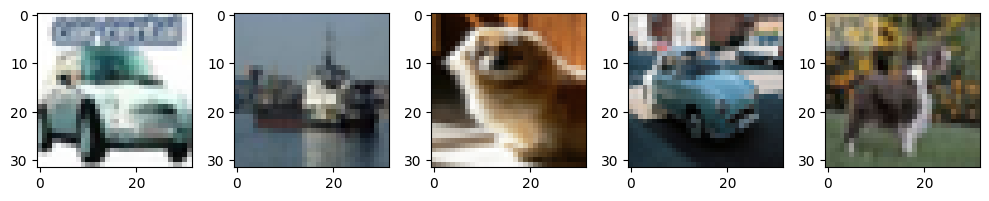

In [7]:
#Showing pictures

# Create a figure with subplots to display multiple images
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Loop to display 10 images
for i in range(5):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    img = X[i].reshape(3, 32, 32).permute(1, 2, 0)  # Reshape and permute the image tensor
    plt.imshow(img.detach().numpy())  # Convert to NumPy and display

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show all images

In [77]:
import torch
import torch.nn.functional as F

class linear:
    def __init__(self, input_size, output_size):
        self.weights = torch.randn(input_size, output_size, dtype=torch.float32) * 0.3
        self.biases = torch.zeros(output_size, dtype=torch.float32) * 0.3

    def forward(self, input):
        self.input = input.float()
        self.output = torch.mm(self.input, self.weights) + self.biases
        return self.output

    def __call__(self, X):
        return self.forward(X)

class convolutional:
    def __init__(self, input_depth, kernel_size, n_kernels):
        self.input_depth = input_depth
        self.kernel_size = kernel_size
        self.n_kernels = n_kernels
        self.kernels = torch.randn(n_kernels, input_depth, kernel_size, kernel_size, dtype=torch.float32) * 0.3
        self.biases = torch.zeros(n_kernels, dtype=torch.float32) * 0.3

    def forward(self, input):
        self.input = input.float()
        output_height = self.input.shape[2] - self.kernel_size + 1
        output_width = self.input.shape[3] - self.kernel_size + 1
        self.output = torch.zeros((self.input.shape[0], self.n_kernels, output_height, output_width), dtype=torch.float32)

        for i in range(self.input.shape[0]):  # Iterate over batch size
            for j in range(self.n_kernels):  # Iterate over kernels
                self.output[i, j] = F.conv2d(self.input[i].unsqueeze(0), self.kernels[j].unsqueeze(0)) + self.biases[j]
        
        return self.output 
    
    def __call__(self,X):
        return self.forward(X)

class sequential:
    def __init__(self, layers):
        self.layers = layers      

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class tanh:
    def __call__(self, x):
        return torch.tanh(x)

class reshape():
    def __init__(self, output_shape):
        self.output_shape = output_shape

    def __call__(self, X):
        return self.forward(X)

    def forward(self, input):
        print(f"Reshape Input shape : {input.shape}")
        batch_size = input.shape[0]
        self.output = input.view(batch_size, -1)  # Flatten the input dynamically
        print(f"Reshape Output shape : {self.output.shape}")
        return self.output


In [78]:
# Define your kernel size and number of kernels
kernel_size = 3
n_kernels = 2

# Build the model
model = sequential([
    convolutional(3, kernel_size, n_kernels), tanh(),  # First conv layer
    convolutional(n_kernels, kernel_size, n_kernels), tanh(),  # Second conv layer
    convolutional(n_kernels, kernel_size, n_kernels), tanh(),  # Third conv layer
    reshape([n_kernels * 26 * 26]),  # Reshape to a flat vector
    tanh(),
    linear(n_kernels * 26 * 26, 10),  # Match the size expected
    tanh()
])

# Create a dummy input for testing
X = torch.randn(10000, 3, 32, 32)  # Batch size of 10000, 3 channels, 32x32 image

# Forward pass
output = model(X)
print(output.shape)  # Check the output shape

Reshape Input shape : torch.Size([10000, 2, 26, 26])
Reshape Output shape : torch.Size([10000, 1352])
torch.Size([10000, 10])
